# <center> DATA 512: A1 </center>
<center>Madalyn Li <br>
Fall 2021</center>

This notebook provides detailed steps to acquire, process, and analyze the monthly desktop and mobile traffic data from the Wikimedia REST API.

In [1]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt

### 1. Acquiring Data

In the first step, we want to obtain our data from the PageCounts and PageView API endpoints. The final data pull for this step will include 5 JSON source data files of monthly desktop and mobile traffic for each API.

This following API sample code documentation was used as a reference: https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb

In [2]:
# Create API endpoints for Pagecounts and Pageviews

endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

**Selecting Parameters**<br>

The parameters selected below are specific to the purpose of this data analysis project. Specifically, from the Legacy Pagecounts API, the traffic counts of mobile-site and desktop-site access starting from December 2007 to August 2021 were selected. From the Pageviews API, traffic counts of desktop, mobile-app, and mobile-web access starting from December 2007 to August 2021 were selected. <br>

In addition, it is important to note that since the Pageview API includes traffic data for web crawlers and spiders, we have filtered *'agent = user'* to specify organic user traffic in our data pull. The Pagecount API, however, does not have this option to filter. 

In [3]:
# Select parameters for each API query

param_pagecounts_mobilesite = {"project" : "en.wikipedia.org",
                 "access" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2021080100"
                    }

param_pagecounts_desktopsite = {"project" : "en.wikipedia.org",
                 "access" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2021080100"
                    }

param_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    "end" : '2021081000'
                        }

param_pageviews_mobileapp = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    "end" : '2021081000'
                        }

param_pageviews_mobileweb = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    "end" : '2021081000'
                        }

headers = {
    'User-Agent': 'https://github.com/madalynli',
    'From': 'mli2324@uw.edu'
}

In [4]:
# Define function api_call to query API data to a list

def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
# Create API list for each API name and access type using api_call function

pagecounts_mobilesite = api_call(endpoint_pagecounts, param_pagecounts_mobilesite)
pagecounts_desktopsite = api_call(endpoint_pagecounts, param_pagecounts_desktopsite)
pageviews_desktop = api_call(endpoint_pageviews, param_pageviews_desktop)
pageviews_mobileapp = api_call(endpoint_pageviews, param_pageviews_mobileapp)
pageviews_mobileweb = api_call(endpoint_pageviews, param_pageviews_mobileweb)

**Saving JSON files** <br>

In this step, the API queries are saved as JSON files following the standard naming convention: *apiname_accesstype_firstmonth-lastmonth.json*.

The following JSON documentation provided by Kite was used for reference: <br>https://www.kite.com/python/docs/json.dump

In [6]:
# Save API lists to JSON files with the specified naming convention

json.dump(pagecounts_mobilesite, open("pagecounts_mobile-site_200712-202108.json", "w"))
json.dump(pagecounts_desktopsite, open("pagecounts_desktop-site_200712-202108.json", "w"))
json.dump(pageviews_desktop, open("pageviews_desktop_200712-202108.json", "w"))
json.dump(pageviews_mobileapp, open("pageviews_mobile-app_200712-202108.json", "w"))
json.dump(pageviews_mobileweb, open("pageviews_mobile-web_200712-202108.json", "w"))

### 2. Processing Data

After we have acquired our data source, the next step is to clean and process the data to prepare it for analysis. The goal for this section is to produce a csv file that:

- Combines mobile app and mobile web traffic values from the Pageview API.
- Separates the value of timestamp to year and month.
- Replaces all null count values to 0.
- Formats the data to include the following headers: year, month, pagecount_all_views, pagecount_desktop_views, pagecount_mobile_views, pageview_all_views, pageview_desktop_views, pageview_mobile_views.

**Converting API queries to a DataFrame**<br>

In order to easily manipulate and clean the data, the API query list should be converted to a Data Frame. The code below creates a blank default list named *data* and parses through the specified key values in the 5 API lists and then appends those values to the new single list *data*. Next the list is converted to a Data Frame using pandas.

The following article written by Alexandra Yanina was used for reference:<br>
https://towardsdatascience.com/query-apis-with-json-output-in-python-5e16182a9df

In [7]:
# Appends all API lists to one single list name data

data = []
for response in pagecounts_mobilesite['items']:  
    data.append({
        "access": response.get('access-site'),
        "timestamp": response.get('timestamp'),
        "count": response.get('count')   
    })

for response in pagecounts_desktopsite['items']:  
    data.append({
        "access": response.get('access-site'),
        "timestamp": response.get('timestamp'),
        "count": response.get('count')   
    })
    
for response in pageviews_desktop['items']:  
    data.append({
        "access": response.get('access'),
        "timestamp": response.get('timestamp'),
        "count": response.get('views')   
    })
    
for response in pageviews_mobileapp['items']:  
    data.append({
        "access": response.get('access'),
        "timestamp": response.get('timestamp'),
        "count": response.get('views')   
    })
    
for response in pageviews_mobileweb['items']:  
    data.append({
        "access": response.get('access'),
        "timestamp": response.get('timestamp'),
        "count": response.get('views')   
    })

In [8]:
# Convert appended list into a DataFrame

df = pd.DataFrame(data)

**Combining mobile app and mobile web traffic values**<br>

The code below combines the mobile-app and mobile-web traffic data in the Pageview API by replacing the access type values to *'pageview_mobile_views'*. This step skips combining the count values of both access types since in a later step below, the data will be converted to a pivot table which will automatically sum the values. 

In [9]:
# Combine mobile-app and mobile-web traffic data

df["access"].replace({"mobile-app": "pageview_mobile_views", "mobile-web": "pageview_mobile_views"}, inplace=True)

**Renaming Access Types**

Similar to the previous step above, this line of code below renames the values of the other access types to the more standard format of: *apiname_access-type*.

In [10]:
# Rename access type values to standardized format

df["access"].replace({"mobile-site": "pagecount_mobile_views", "desktop-site": "pagecount_desktop_views", "desktop": "pageview_desktop_views"}, inplace=True)

**Separating Timestamp Values**<br>

In some cases, the timestamp value format varies and can be different than what is shown here. For this instance though, I have selected a substring of the timestamp value to obtain the year and month values since I know the exact positioning of these values and the fomrat is consistent throughout. The code below adds additional columns for the year and month which are derived from slicing the timestamp as a string. 

In [11]:
# Create new year and month columns by slicing the timestamp string

df['year'] = df['timestamp'].str.slice(0,4)

df['month'] = df['timestamp'].str.slice(4,6)

**Creating a Pivot Table**

The code below creates a new data frame with the pivot table function that formats the data to the view we want. The pivot table transforms the access type values to columns, indexes by year and month, and sums the total count values.

The following documentation provivided by Pandas was used as reference:<br>
https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

In [12]:
# Create a pivot table with the data frame

df_pivot = df.pivot_table(values = 'count', columns = ['access'], index = ['year','month']).reset_index()

**Replacing Null Values**

Since the original dataset includes null values for the years that data is not available, I replaced these values with a 0 value below.

In [13]:
# Replace all null values in the data frame with 0

df_pivot = df_pivot.fillna(0)

**Adding and Sorting Headers**

Since the final format of our table includes an all_views column for each API, I summed their respective count values (both desktop and mobile) for each API.

Next, I re-sorted the headers into the format and order I want to see them displayed in. The data frame is now cleaned and ready to be analyzed!

The following JSON documentation provided by Kite was used for reference:<br>
https://www.kite.com/python/answers/how-to-reorder-columns-in-a-pandas-dataframe-in-python

In [14]:
# Create all_views columns for each API by adding their respective count values

df_pivot['pagecount_all_views'] = df_pivot['pagecount_desktop_views'] + df_pivot['pagecount_mobile_views']
df_pivot['pageview_all_views'] = df_pivot['pageview_desktop_views'] + df_pivot['pageview_mobile_views']

# Reorder headers

df_pivot = df_pivot[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

**Saving Final Data File**

Finally, in this step, I save the final cleaned data file as a CSV with the appropriate naming format.

In [15]:
# Save cleaned data to a CSV file

df_pivot.to_csv('en-wikipedia_traffic_200712-202108.csv')

**Preview of Cleaned Data**

Below is a preview of what our final cleaned data set looks like.

In [16]:
# Display the first five rows of the final data set

df_pivot.head()

access,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


### 3. Analyzing Data

Now that we have our clean data file, we can finally proceed with the data analysis. In particular, we want to create a time series graph of total desktop, mobile, and overall traffic during the overlapping years that data was available on both APIs. Below are the additional steps taken to adjust the data to prepare it for plotting and finally the steps to  graph the dataset for visualization purposes. 

**Reformatting the date column**

In the code below, the year and month columns are combined and reformatted. Doing this makes labeling the x-axis in the graph easier since both values are lumped into just one value containing all the information. To implement this, I concatenated both values with a dash in between.

In [17]:
# Create a year-month column that concatenates the year and month values

df_pivot['year-month'] = df_pivot['year'] + "-" + df_pivot['month']

**Filtering to Months where all traffic data is Available**

Since all traffic data is not always available on certain years, I decided to filter these values out since they may skew the final result and display a lower total number than usual. To implement this, I filtered the data frame by using the *and* operator to select all access-type columns where the traffic data was not equal to 0. 

In [18]:
# Filter to where all traffic data counts do not equal to 0

df_pivot = df_pivot[(df_pivot['pagecount_mobile_views'] != 0) & (df_pivot['pageview_mobile_views'] != 0) & (df_pivot['pagecount_desktop_views'] != 0) & (df_pivot['pageview_desktop_views'] != 0)]

**Plotting Data**

The steps to plot the data and clean up the results are listed below. I combined the steps into a single cell to run since the code to clean and process the results are all tied to the one graph.  

A ) **Plot the Data** <br>
Plot the data using the pandas *plot( )* function. Here, we specify the x-label as the 'year-month' field. <br>

B ) **Restructure the x-axis labels** <br>
Restructure the x-axis labels by adding missing/skipped tick marks and labels as well as rotating the labels by 90 degrees to make it fit to the visualization better.<br>

The following documentation provided by matplotlib was used as reference:<br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html

C ) **Shift the Legend Position** <br>
Since the legend placement was defaulted inside the graph, I opted to shift the position so that it would not cover any important parts of the main plot.<br>

D ) **Add Axis Labels** <br>
As per the standard for a good and clear visualization, I added x-axis and y-axis labels to provide readers with better context and understanding of our visualization. <br>

E ) **Add a Title** <br>
As per the standard for a good and clear visualization, I added a title to the chart for the readers to understand the purpose of the plot. <br>

F ) **Save as a PNG** <br>
I saved the graph to a PNG file for reference. 

G ) **Display Visualization** <br>
To verify if the results are what I expected, I used plt.show( ) to display the final graph. 

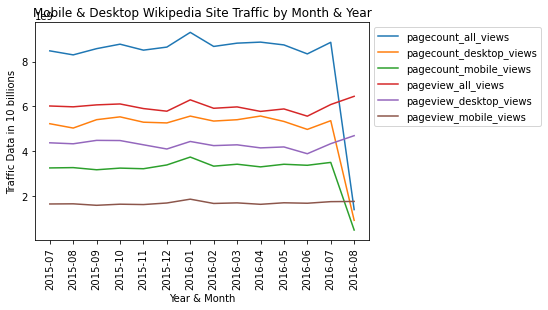

In [19]:
# A) Plot the Data

df_pivot.plot(x = 'year-month')

# B) Restructure the x-axis by rotating the labels and adding additional tick marks

plt.xticks(ticks = range(0,len(df_pivot['year-month'])), labels = df_pivot['year-month'],  rotation=90)

# C) Shift the Legend Position

plt.legend(bbox_to_anchor=(1, 1))

# D) Add x-axis and y-axis labels
plt.xlabel("Year & Month")
plt.ylabel("Traffic Data in 10 billions")

# E) Add a title

plt.title("Mobile & Desktop Wikipedia Site Traffic by Month & Year")

# F) Save the figure as a png

plt.savefig('data_512_a1.png', bbox_inches='tight')

# G) Display the plot to verify results

plt.show()